In [307]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import time

In [308]:
## MODEL PARAMETERS

# Cell
mu_1 = 1/3600        # max growth rate of strain 1 (in 1/sec)
mu_2 = 1/3600       # max growth rate of strain 2 (in 1/sec)
Y = 250               # biomass yield (in g biomass/g glucose)

# Glucose
Ks = 4*10**-6         # rate of nutrient consumption by Monod kinetics (in g/mL)

# Antibiotics
Km1 = 3.55*10**-6       # Michaelis-Menton rate constant for antibiotic 1 inactivation by C1 (in g/mL)
Vmax1 = 4*10**0/3600    # Maximum antibiotic 1 inactivation (by C1) rate (in mL/(g.sec))
IC1 = 2.5*10**-6          # antibiotic 1 concentration at which C2 growth rate is halved (in g/mL)
n1 = 40
Km2 = 3.55*10**-6       # Michaelis-Menton rate constant for antibiotic 2 inactivation by C2 (in g/mL)
Vmax2 = 3*10**0/3600    # Maximum antibiotic 2 inactivation (by C2) rate (in 1/sec)
IC2 = 2.5*10**-6          # antibiotic 2 concentration at which C1 growth rate is halved (in g/mL)
n2 = 1

# Diffusion
Qhf = 100                 # pressure parameter for cell diffusion
Phf = 100                 # friction parameter for cell diffusion
DC = 20000
DS = 200              # diffusion coefficient of glucose (in um^2/sec)
DA1 = 50             # diffusion coefficient of antibiotic 1 (in um^2/sec)
DA2 = 50             # diffusion coefficient of antibiotic 2 (in um^2/sec)

# Initial condition
S0 = 0.4            # glucose concentration in feed medium (in g/mL)
A10 = 15*10**-6           # antiobiotic 1 concentration in feed medium (in g/mL)
A20 = 15*10**-6           # antiobiotic 2 concentration in feed medium (in g/mL)
f1 = 0.3              # initial density of loading sites for C1 (fraction of mesh points)
f2 = 0.25             # initial density of loading sites for C2 (fraction of mesh points)
C0 = 100             # inital biomass density at loading sites (dimensionless)

In [309]:
# Frame width (x and y axis - assuming square frame) in um
Len = 15000
# Space desolution in um
dx = 50 
dx0 = dx/Len
# Time Resolution in sec
dt = 1
dtau = dt*mu1
# Time steps
T = 200000
# Number of divisions in space
Lx = int(Len/dx)

res = dt/dx**2 

print("Frame dimensions are", Len, "X", Len, "micrometer sq. \n dx = ", dx, "micrometers")
print("Simulation time is", dt*T, "seconds \n dt =", dt, "seconds")
print("dtau / dx0^2 = ", res)

Frame dimensions are 15000 X 15000 micrometer sq. 
 dx =  50 micrometers
Simulation time is 200000 seconds 
 dt = 1 seconds
dtau / dx0^2 =  0.0004


In [310]:
# DIMENSIONLESS PARAMETERS

dC = DC/(Len**2)                # dispersal constant of cells
dS = DS/(mu1*Len**2)            # diffusion constant of glucose
dA1 = DA1/(mu1*Len**2)          # diffusion constant of antibiotic 1
dA2 = DA2/(mu1*Len**2)          # diffusion constant of antibiotic 2

mu_r = mu2/mu1                 # relative instrinsic growth rate (of C2 wrt C1)

beta = Cmax/(Y*Ks)             # Glucose utilization

alpha1 = Km1/IC1               # Antibiotic 1 strength
alpha2 = Km2/IC2               # Antibiotic 2 strength

gamma1 = Vmax1*Cmax/(mu1*IC1)  # Benefit from C1 to C2 by antibiotic 1 inactivation 
gamma2 = Vmax2*Cmax/(mu1*IC2)  # Benefit from C2 to C1 by antibiotic 2 inactivation

NameError: name 'Cmax' is not defined

In [311]:
## DEFINE FUNCTIONS

def q(M):
    Q = M/(Qhf+M)
    return Q

def p(M):
    P = Phf/(Phf+M)
    return P

def discrete_laplacian(M):
    """Get the discrete Laplacian of matrix M"""
    L = -4*M
    L += np.roll(M, (0,-1), (0,1)) # right neighbor
    L += np.roll(M, (0,+1), (0,1)) # left neighbor
    L += np.roll(M, (-1,0), (0,1)) # top neighbor
    L += np.roll(M, (+1,0), (0,1)) # bottom neighbor
    
    return L

def divide(M1,M2):
    """To divide two numpy arrays M1/M2 element-wise and avoide division by zero"""
    f = np.divide(M1, M2, out=np.zeros_like(M1), where=M2!=0)
    return f

def sp_laplacian(M, S1, S2):
    
    Mcf = M*divide(S1, S1+S2)
    M_r = np.roll(M, (0,-1), (0,1)) # right neighbor
    M_l = np.roll(M, (0,+1), (0,1)) # left neighbor
    M_t = np.roll(M, (-1,0), (0,1)) # top neighbor
    M_b = np.roll(M, (+1,0), (0,1)) # bottom neighbor
    
    cf = divide(S1, S1+S2)
    cf_r = np.roll(cf, (0,-1), (0,1)) # right neighbor
    cf_l = np.roll(cf, (0,+1), (0,1)) # left neighbor
    cf_t = np.roll(cf, (-1,0), (0,1)) # top neighbor
    cf_b = np.roll(cf, (+1,0), (0,1)) # bottom neighbor
    
    D = (cf_r*M_r + cf_r*cf_t - cf_b)*(M_t - M_b)/4 + cf*discrete_laplacian(M)
    
    return D

def nbr_sum(M):
    M_sum = np.roll(M, (0,-1), (0,1)) # right neighbor
    M_sum += np.roll(M, (0,+1), (0,1)) # left neighbor
    M_sum += np.roll(M, (-1,0), (0,1)) # top neighbor
    M_sum += np.roll(M, (+1,0), (0,1)) # bottom neighbor
    
    return M_sum
    

def sp_nbr_sum(M, S1, S2):
    
    M_r = np.roll(M, (0,-1), (0,1)) # right neighbor
    M_l = np.roll(M, (0,+1), (0,1)) # left neighbor
    M_t = np.roll(M, (-1,0), (0,1)) # top neighbor
    M_b = np.roll(M, (+1,0), (0,1)) # bottom neighbor
    
    cf = divide(S1, S1+S2)
    cf_r = np.roll(cf, (0,-1), (0,1)) # right neighbor
    cf_l = np.roll(cf, (0,+1), (0,1)) # left neighbor
    cf_t = np.roll(cf, (-1,0), (0,1)) # top neighbor
    cf_b = np.roll(cf, (+1,0), (0,1)) # bottom neighbor
    
    D = (cf_r - cf_l)*(M_r - M_l)/4 + (cf_t - cf_b)*(M_t - M_b)/4 + cf*discrete_laplacian(M)
    
    return D

def D(M, Cpack, rho):
    '''Density dependent diffusion function for external molecules'''
    f = (Cpack-rho*M)/(Cpack+rho*M/2)
    return f

def den_dep_diffusion_mol(S, M, rho):
    '''finite difference approximation of the diffusion term for S'''
    
    S_r = np.roll(S, (0,-1), (0,1)) # right neighbor
    S_l = np.roll(S, (0,+1), (0,1)) # left neighbor
    S_t = np.roll(S, (-1,0), (0,1)) # top neighbor
    S_b = np.roll(S, (+1,0), (0,1)) # bottom neighbor
    
    M_r = np.roll(M, (0,-1), (0,1)) # right neighbor
    M_l = np.roll(M, (0,+1), (0,1)) # left neighbor
    M_t = np.roll(M, (-1,0), (0,1)) # top neighbor
    M_b = np.roll(M, (+1,0), (0,1)) # bottom neighbor
    
    Dif = (D(M_r, Cpack, rho) + D(M_t, Cpack, rho) - D(M_b, Cpack, rho) - D(M_l, Cpack, rho))*(S_r+S_t-S_b-S_l)/4 \
        + D(M, Cpack, rho)*discrete_laplacian(S)
    
    return Dif

def create_circular_mask(h, w, center=None, radius=None):

    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask

In [312]:
def initialize_2d(C0, S0, A10, A20):
    
    '''Sampling a fraction of mesh points uniformly randomly and loading each with a fixed cell density'''
    
    C1 = np.zeros((Lx+1,Lx+1))
    C2 = np.zeros((Lx+1,Lx+1))
    S = np.ones((Lx+1,Lx+1))*S0
    A1 = np.ones((Lx+1,Lx+1))*A10
    A2 = np.ones((Lx+1,Lx+1))*A20
    
    # sample random points to load bacteria
    n1 = int(np.ceil(f1*(Lx-1)*(Lx-1)))
    n2 = int(np.ceil(f2*(Lx-1)*(Lx-1)))
    ind1 = np.random.randint(low=1, high=int((Lx-1)*(Lx-1)), size=n1)
    ind2 = np.random.randint(low=1, high=int((Lx-1)*(Lx-1)), size=n2)

    for i in ind1:
        x = int(np.ceil(i/(Lx-1)))
        y = i%(Lx-1)+1
        C1[x,y] = np.random.exponential(C0,size=1)
    
    for i in ind2:
        x = int(np.ceil(i/(Lx-1)))
        y = i%(Lx-1)+1
        C2[x,y] = np.random.exponential(C0,size=1)
    
    # mask a circular region in the middle to load cells. Clear cells everywhere else
    h, w = C1.shape[:2]
    mask1 = create_circular_mask(h, w, radius=10)
    C1[~mask1] = 0
    C2[~mask1] = 0
    mask2 = create_circular_mask(h, w, radius=57)
    C1[~mask2] *= 1
    C2[~mask2] *= 1
        
    return(C1, C2, S, A1, A2)

def initialize_linear(C0, S0, A10, A20):
    
    C1 = np.zeros((Lx+1,Lx+1))
    C2 = np.zeros((Lx+1,Lx+1))
    S = np.ones((Lx+1,Lx+1))*S0
    A1 = np.ones((Lx+1,Lx+1))*A10
    A2 = np.ones((Lx+1,Lx+1))*A20
    
    n1 = int(np.ceil(f1*(Lx-1)))
    n2 = int(np.ceil(f2*(Lx-1)))
    
    ind1 = np.random.randint(low=1, high=int(Lx-1), size=n1)
    ind2 = np.random.randint(low=1, high=int(Lx-1), size=n2)

    for i in ind1:
        x = i
        y = int((Lx-1)/2)
        C1[x,y] = np.random.exponential(C0,size=1)
    
    for i in ind2:
        x = i
        y = int((Lx-1)/2)
        C2[x,y] = np.random.exponential(C0,size=1)
        
    return(C1, C2, S, A1, A2)
    

In [313]:
def update(C1, C2, S, A1, A2):
    
    tot = C1 + C2 # total biomass density
    Q = q(tot)
    P = p(tot)
    
    #Sdiff = res*dS*den_dep_diffusion_mol(S, tot, rho) - dtau*beta*(C1+mu_r*C2)*S/(1+S)
    #A1diff = res*dA1*den_dep_diffusion_mol(A1, tot, rho) - dtau*gamma1*A1*C1/(alpha1+A1)
    #A2diff = res*dA2*den_dep_diffusion_mol(A2, tot, rho) - dtau*gamma2*A2*C2/(alpha2+A2)
    Sdiff = res*DS*discrete_laplacian(S) - dt*(mu_1*C1/(1+(A2/IC2)**n2)+mu_2*C2/(1+(A1/IC1)**n1))*S/(Y*(Ks+S))
    A1diff = res*DA1*discrete_laplacian(A1) - dt*Vmax1*A1*C1/(1+(A2/IC2)**n2)
    A2diff = res*DA2*discrete_laplacian(A2) - dt*Vmax2*A2*C2/(1+(A2/IC2)**n2)
    
    # biomass growth rates
    M1 = mu_1*S/((Ks+S)*(1+(A2/IC2)**n2))
    M2 = mu_2*S/((Ks+S)*(1+(A1/IC1)**n1))
    scrM = M1*C1 + M2*C2
    
    #C1diff = dt*M1*C1*(1-Q) + res*DC*(P*discrete_laplacian(divide(scrM*Q*C1,tot)) - divide(scrM*Q*C1,tot)*discrete_laplacian(P))
    #C2diff = dt*M2*C2*(1-Q) + res*DC*(P*discrete_laplacian(divide(scrM*Q*C2,tot)) - divide(scrM*Q*C2,tot)*discrete_laplacian(P))
    
    C1diff = dt*M1*C1*(1-Q) + res*DC*discrete_laplacian(divide(scrM*Q*C1,tot))
    C2diff = dt*M2*C2*(1-Q) + res*DC*discrete_laplacian(divide(scrM*Q*C2,tot)) # for P=1 everywhere
    
    C1 += C1diff
    C2 += C2diff
    S += Sdiff
    A1 += A1diff
    A2 += A2diff
    
    # Remove negative values
    C1[C1 < 0] = 0
    C2[C2 < 0] = 0
    S[S < 0] = 0 
    A1[A1 < 0] = 0 
    A2[A2 < 0] = 0
    
    #################################!!!!!!!!!!!!!!!!!!!!!!!
    #C1 = np.nan_to_num(C1)
    #C2 = np.nan_to_num(C2)
    #A1 = np.nan_to_num(A1)
    #A2 = np.nan_to_num(A2)
    #S = np.nan_to_num(S)
    
    # Reflecting boundaries
    
    C1[0,:], C2[0,:], S[0,:], A1[0,:], A2[0,:] = C1[1,:], C2[1,:], S[1,:], A1[1,:], A2[1,:]            # top
    C1[-1,:], C2[-1,:], S[-1,:], A1[-1,:], A2[-1,:] = C1[-2,:], C2[-2,:], S[-2,:], A1[-2,:], A2[-2,:]  # bottom
    C1[:,0], C2[:,0], S[:,0], A1[:,0], A2[:,0] = C1[:,1], C2[:,1], S[:,1], A1[:,1], A2[:,1]            # left
    C1[:,-1], C2[:,-1], S[:,-1], A1[:,-1], A2[:,-1] = C1[:,-2], C2[:,-2], S[:,-2], A1[:,-2], A2[:,-2]  # right
                            
    return C1, C2, S, A1, A2

def update_new(C1, C2, S, A1, A2):
    
    tot = C1 + C2 # total biomass density
    Q = q(tot)
    P = 1 - Q
    
    Sdiff = res*dS*den_dep_diffusion_mol(S, tot, rho) - dtau*beta*(C1+mu_r*C2)*S/(1+S)
    A1diff = res*dA1*den_dep_diffusion_mol(A1, tot, rho) - dtau*gamma1*A1*C1/(alpha1+A1)
    A2diff = res*dA2*den_dep_diffusion_mol(A2, tot, rho) - dtau*gamma2*A2*C2/(alpha2+A2)
    
    # biomass growth rates
    M1 = S/((1+S)*(1+A2))
    M2 = mu_r*S/((1+S)*(1+A1))
    scrM = M1*C1 + M2*C2
    
    #C1diff = dtau*M1*C1*P + res*dC*(P*discrete_laplacian(divide(scrM*Q*C1,tot)) - divide(scrM*Q*C1,tot)*discrete_laplacian(P))
    #C2diff = dtau*M2*C2*P + res*dC*(P*discrete_laplacian(divide(scrM*Q*C2,tot)) - divide(scrM*Q*C2,tot)*discrete_laplacian(P))
    C1diff = dtau*M1*C1*P + res*dC*(P*nbr_sum(divide(scrM*Q*C1,tot)) - divide(scrM*Q*C1,tot)*nbr_sum(P))
    C2diff = dtau*M2*C2*P + res*dC*(P*nbr_sum(divide(scrM*Q*C2,tot)) - divide(scrM*Q*C2,tot)*nbr_sum(P))
    
    C1 += C1diff
    C2 += C2diff
    S += Sdiff
    A1 += A1diff
    A2 += A2diff
    
    # Remove negative values
    S[S < 0] = 0 
    A1[A1 < 0] = 0 
    A2[A2 < 0] = 0
    
    #################################!!!!!!!!!!!!!!!!!!!!!!!
    #C1 = np.nan_to_num(C1)
    #C2 = np.nan_to_num(C2)
    #A1 = np.nan_to_num(A1)
    #A2 = np.nan_to_num(A2)
    #S = np.nan_to_num(S)
    
    # Reflecting boundaries
    
    C1[0,:], C2[0,:], S[0,:], A1[0,:], A2[0,:] = C1[1,:], C2[1,:], S[1,:], A1[1,:], A2[1,:]            # top
    C1[-1,:], C2[-1,:], S[-1,:], A1[-1,:], A2[-1,:] = C1[-2,:], C2[-2,:], S[-2,:], A1[-2,:], A2[-2,:]  # bottom
    C1[:,0], C2[:,0], S[:,0], A1[:,0], A2[:,0] = C1[:,1], C2[:,1], S[:,1], A1[:,1], A2[:,1]            # left
    C1[:,-1], C2[:,-1], S[:,-1], A1[:,-1], A2[:,-1] = C1[:,-2], C2[:,-2], S[:,-2], A1[:,-2], A2[:,-2]  # right
                            
    return C1, C2, S, A1, A2

In [314]:
# Simulate

update_every = 500 # number of time steps after which data is stored
C1_time = []
C2_time = []
S_time = []
A1_time = []
A2_time = []
C1, C2, S, A1, A2 = initialize_linear(C0, S0, A10, A20)

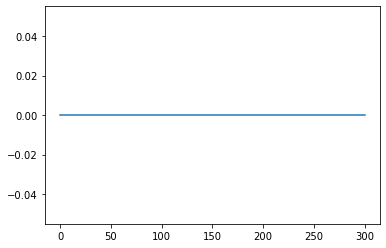

In [315]:
plt.plot(C1[:,150])

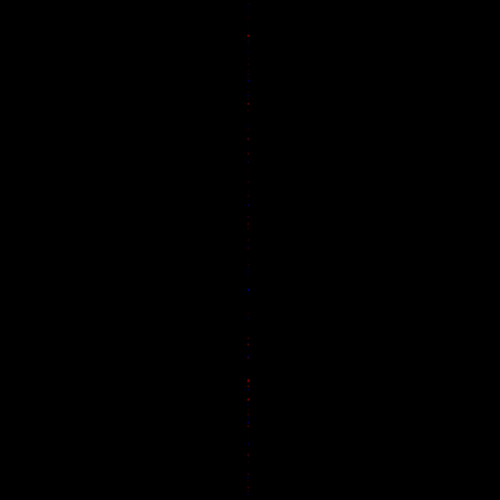

In [316]:
# Create image of final density distribution for C1 (Red) and C2 (Blue)

brightness = 1/4  #factor to multiply brightness

rgb = np.zeros((Lx+1,Lx+1,3), 'uint8')
#C1[C1<0] = 0
#C2[C2<0] = 0
rgb[..., 0] = C1*brightness
rgb[..., 2] = C2*brightness
rgb[..., 0][rgb[..., 0]>255] = 255
rgb[..., 2][rgb[..., 2]>255] = 255
img = Image.fromarray(rgb)
img.resize((500,500), Image.ANTIALIAS)

In [317]:
np.max(C2)

496.67939843978087

In [318]:
start = time.time()

for tt in range(T):
    if tt%update_every == 0:
        C1_time.append(C1.copy())
        C2_time.append(C2.copy())
        S_time.append(S.copy())
        A1_time.append(A1.copy())
        A2_time.append(A2.copy())
    C1, C2, S, A1, A2 = update(C1, C2, S, A1, A2)

stop = time.time()

print("end of simultaion. Time taken = {} seconds".format(stop-start))

end of simultaion. Time taken = 3954.4772477149963 seconds


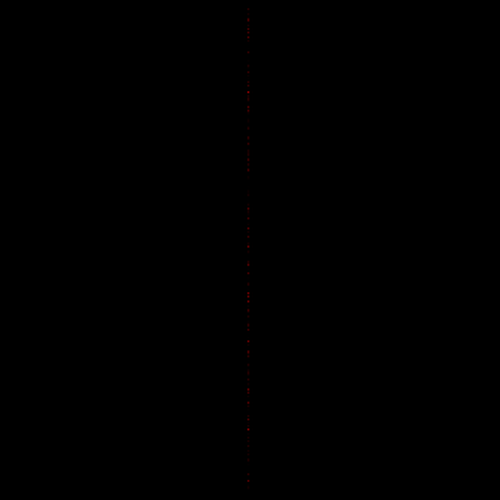

In [177]:
# Create image of final density distribution for C1 (Red) 

brightness = 1/3 # factor to multiply brightness

rgb = np.zeros((Lx+1,Lx+1,3), 'uint8')
C1_time[-1][C1_time[-1]<0] = 0
rgb[..., 0] = C1_time[-1]*brightness
rgb[..., 0][rgb[..., 0]>255] = 255
img = Image.fromarray(rgb)
img.resize((500,500), Image.ANTIALIAS)

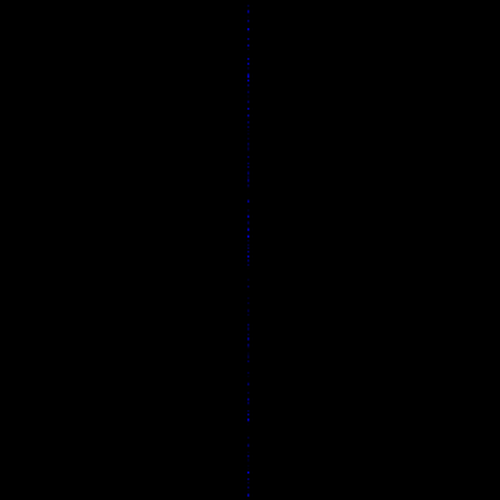

In [176]:
# Create image of final density distribution for C2 (Blue) 

brightness = 1 # factor to multiply brightness

rgb = np.zeros((Lx+1,Lx+1,3), 'uint8')
C2_time[-1][C2_time[-1]<0] = 0
rgb[..., 2] = C2_time[-1]*brightness
rgb[..., 2][rgb[..., 2]>255] = 255
img = Image.fromarray(rgb)
img.resize((500,500), Image.ANTIALIAS)

In [306]:
# Create GIF
brightness = 1/1.1 # factor to multiply brightness

images=[]
C1_time = C1_time
C2_time = C2_time
for i in range(len(C1_time)):
    rgb = np.zeros((Lx+1,Lx+1,3), 'uint8')
    C1_time[i][C1_time[i]<0] = 0
    C2_time[i][C2_time[i]<0] = 0
    rgb[..., 0] = (C1_time[i])*brightness
    rgb[..., 2] = (C2_time[i])*brightness
    rgb[..., 0][rgb[..., 0]>255] = 255
    rgb[..., 2][rgb[..., 2]>255] = 255
    img = Image.fromarray(rgb)
    images.append(img.resize((500,500), Image.ANTIALIAS))

images[0].save('ball_weak5.gif', format='GIF', append_images=images[1:], save_all=True, duration=1, loop=0)

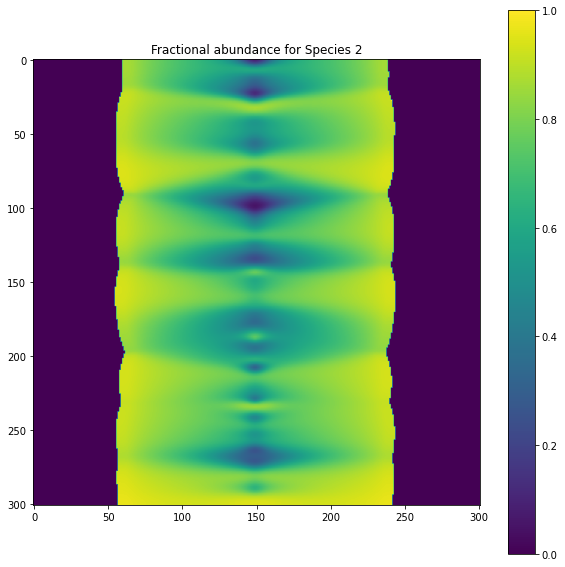

In [249]:
# vmax1 = 80
# vmax2 = 10
frac = divide(C2_time[-1],C1_time[-1]+C2_time[-1])
new = np.zeros((Lx+1,Lx+1))

new[frac > 0.5] = 1
new[frac < 0.5] = 0
plt.figure(figsize = (10,10))
plt.imshow(frac, vmin=0, vmax=1, cmap='viridis')
plt.title('Fractional abundance for Species 2')
plt.colorbar()

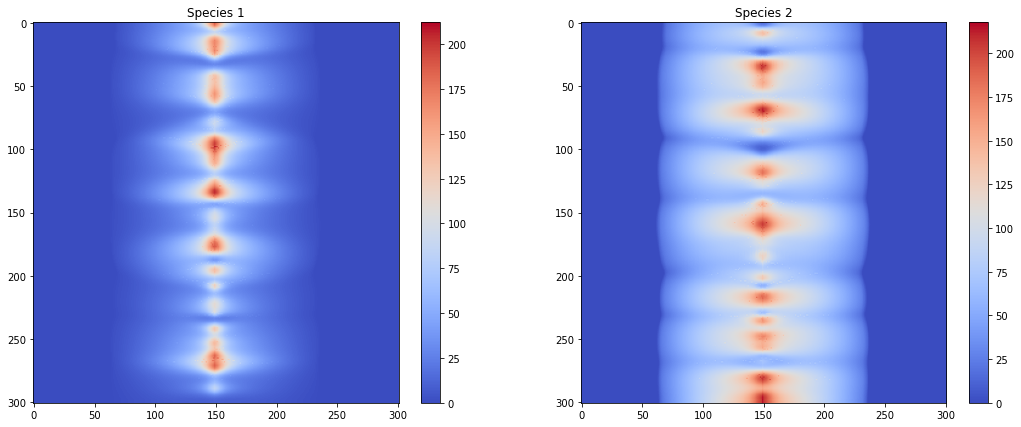

In [250]:
plt.figure(figsize = (18,7))
plt.subplot(1,2,1)
plt.imshow(C1_time[-1], cmap='coolwarm', aspect='auto', label='u=0.25, v=4')
plt.title('Species 1')
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(C2_time[-1], cmap='coolwarm',aspect='auto', label='u=0.25, v=4')
plt.title('Species 2')
plt.colorbar()

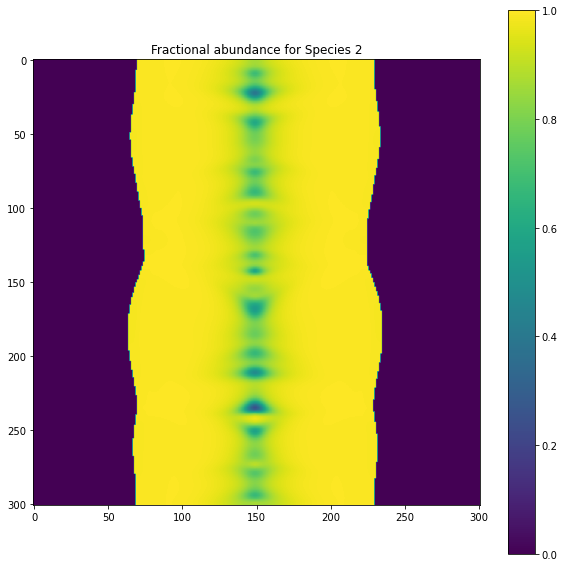

In [263]:
# vmax1 = 4
# vmax2 = 0.5

frac = divide(C2_time[-1],C1_time[-1]+C2_time[-1])
new = np.zeros((Lx+1,Lx+1))

new[frac > 0.5] = 1
new[frac < 0.5] = 0
plt.figure(figsize = (10,10))
plt.imshow(frac, vmin=0, vmax=1, cmap='viridis')
plt.title('Fractional abundance for Species 2')
plt.colorbar()

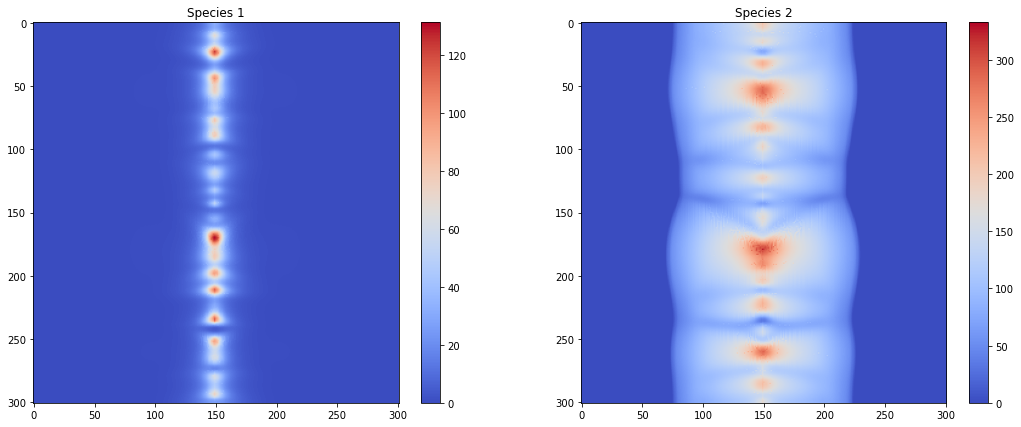

In [264]:
plt.figure(figsize = (18,7))
plt.subplot(1,2,1)
plt.imshow(C1_time[-1], cmap='coolwarm', aspect='auto', label='u=0.25, v=4')
plt.title('Species 1')
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(C2_time[-1], cmap='coolwarm',aspect='auto', label='u=0.25, v=4')
plt.title('Species 2')
plt.colorbar()

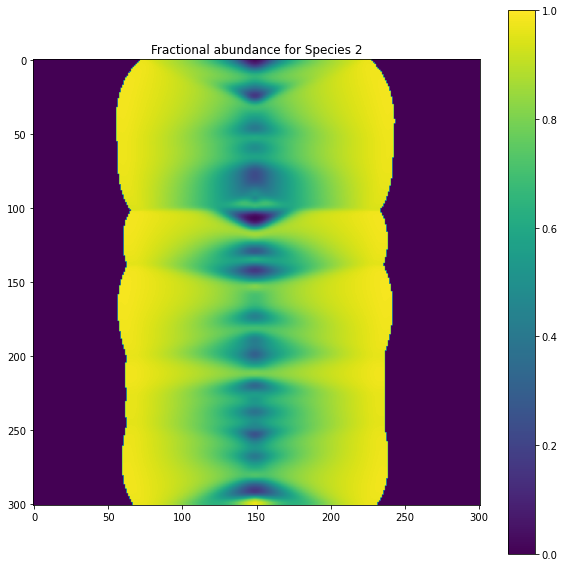

In [280]:
# vmax1 = 4
# vmax2 = 3

frac = divide(C2_time[-1],C1_time[-1]+C2_time[-1])
new = np.zeros((Lx+1,Lx+1))

new[frac > 0.5] = 1
new[frac < 0.5] = 0
plt.figure(figsize = (10,10))
plt.imshow(frac, vmin=0, vmax=1, cmap='viridis')
plt.title('Fractional abundance for Species 2')
plt.colorbar()

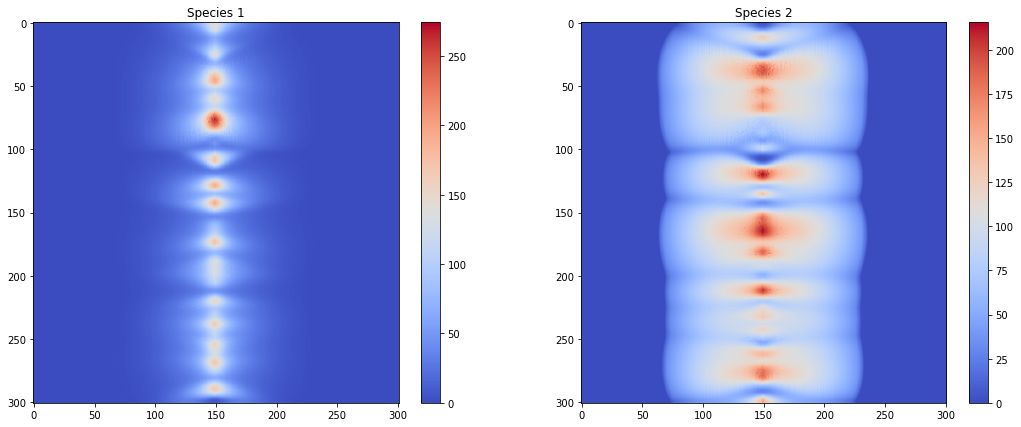

In [282]:
plt.figure(figsize = (18,7))
plt.subplot(1,2,1)
plt.imshow(C1_time[-1], cmap='coolwarm', aspect='auto', label='u=0.25, v=4')
plt.title('Species 1')
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(C2_time[-1], cmap='coolwarm',aspect='auto', label='u=0.25, v=4')
plt.title('Species 2')
plt.colorbar()

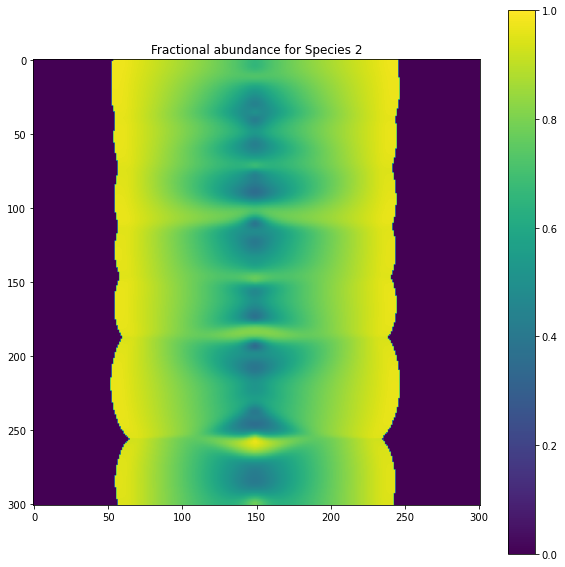

In [304]:
# vmax1 = 4
# vmax2 = 3
# P=1 everywhere

frac = divide(C2_time[-1],C1_time[-1]+C2_time[-1])
new = np.zeros((Lx+1,Lx+1))

new[frac > 0.5] = 1
new[frac < 0.5] = 0
plt.figure(figsize = (10,10))
plt.imshow(frac, vmin=0, vmax=1, cmap='viridis')
plt.title('Fractional abundance for Species 2')
plt.colorbar()

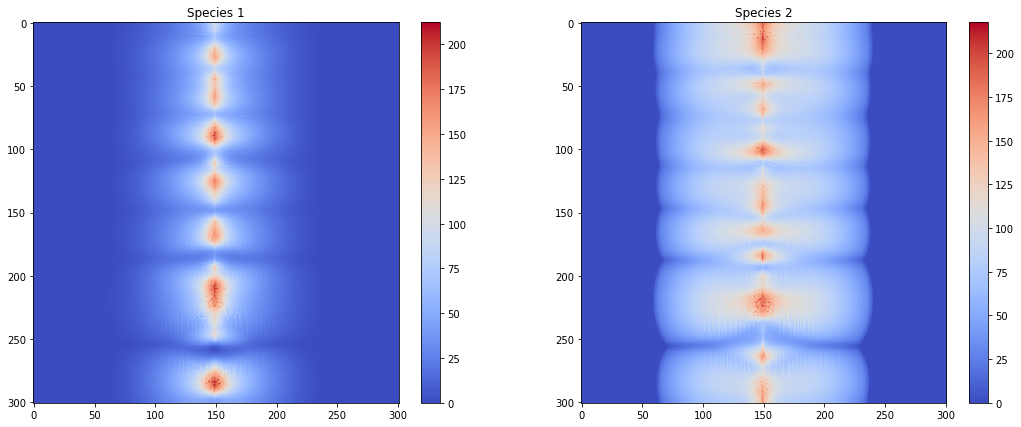

In [305]:
plt.figure(figsize = (18,7))
plt.subplot(1,2,1)
plt.imshow(C1_time[-1], cmap='coolwarm', aspect='auto', label='u=0.25, v=4')
plt.title('Species 1')
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(C2_time[-1], cmap='coolwarm',aspect='auto', label='u=0.25, v=4')
plt.title('Species 2')
plt.colorbar()

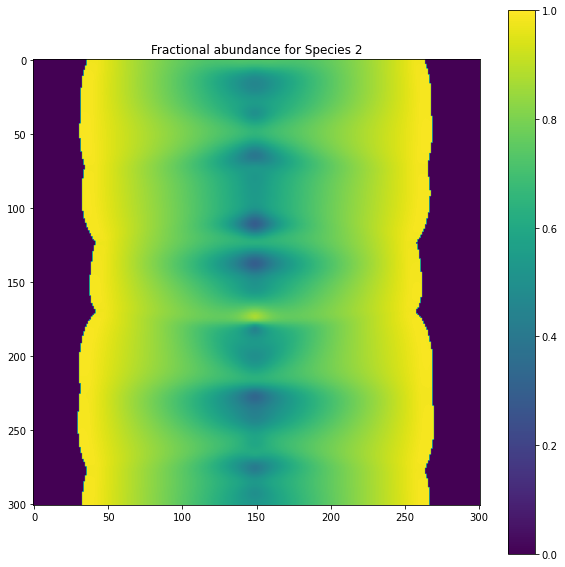

In [319]:
# vmax1 = 4
# vmax2 = 3
# P=1 everywhere
# DC from 10,000 to 20,000

frac = divide(C2_time[-1],C1_time[-1]+C2_time[-1])
new = np.zeros((Lx+1,Lx+1))

new[frac > 0.5] = 1
new[frac < 0.5] = 0
plt.figure(figsize = (10,10))
plt.imshow(frac, vmin=0, vmax=1, cmap='viridis')
plt.title('Fractional abundance for Species 2')
plt.colorbar()

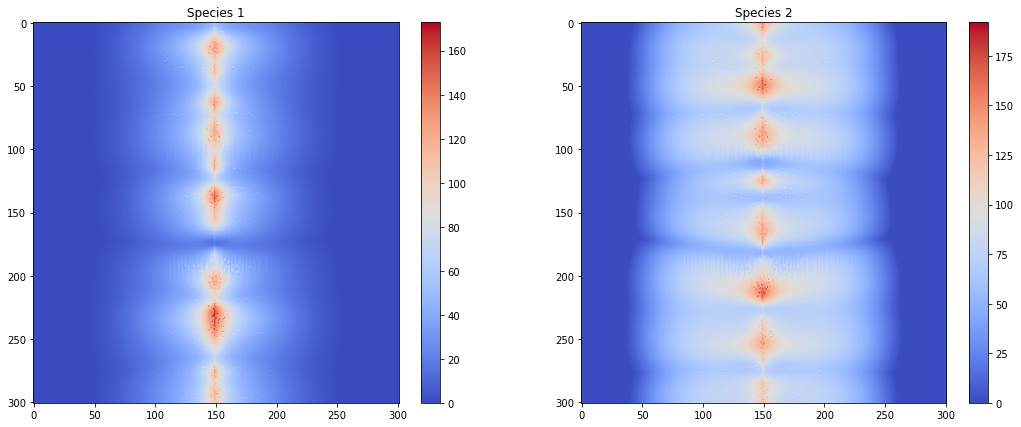

In [320]:
plt.figure(figsize = (18,7))
plt.subplot(1,2,1)
plt.imshow(C1_time[-1], cmap='coolwarm', aspect='auto', label='u=0.25, v=4')
plt.title('Species 1')
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(C2_time[-1], cmap='coolwarm',aspect='auto', label='u=0.25, v=4')
plt.title('Species 2')
plt.colorbar()